In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
import numpy as np
import scipy.signal
from scipy.stats import mode
import matplotlib.pyplot as plt
import pandas as pd

2025-07-09 13:09:29.908594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.14.0


# Inspect Generator

In [3]:
generator = load_model('../../TGAN_model/Profile_generator_GAN_trained_model_random_24-09-2023.h5')

In [4]:
generator.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 profile_input_layer (Input  [(None, 6, 5000, 1)]         0         []                            
 Layer)                                                                                           
                                                                                                  
 downsize1 (Conv2D)          (None, 6, 500, 16)           176       ['profile_input_layer[0][0]'] 
                                                                                                  
 profile_horizontal_model_L  (None, 6, 500, 32)           2592      ['downsize1[0][0]']           
 1 (Conv2D)                                                                                       
                                                                                            

In [5]:
print("Input shape:", generator.input_shape)
print("Output shape:", generator.output_shape)

# plot_model(generator, to_file="generator_architecture.png", show_shapes=True, show_layer_names=True)

Input shape: [(None, 6, 5000, 1), (None, 6, 500, 1)]
Output shape: (None, 6, 5000, 1)


In [6]:
for i, layer in enumerate(generator.layers):
    print(f"{i}: {layer.name} — {layer.__class__.__name__}")
    print("  Input shape:", layer.input_shape)
    print("  Output shape:", layer.output_shape)

0: profile_input_layer — InputLayer
  Input shape: [(None, 6, 5000, 1)]
  Output shape: [(None, 6, 5000, 1)]
1: downsize1 — Conv2D
  Input shape: (None, 6, 5000, 1)
  Output shape: (None, 6, 500, 16)
2: profile_horizontal_model_L1 — Conv2D
  Input shape: (None, 6, 500, 16)
  Output shape: (None, 6, 500, 32)
3: batch_normalization_54 — BatchNormalization
  Input shape: (None, 6, 500, 32)
  Output shape: (None, 6, 500, 32)
4: profile_horizontal_model_L2 — Conv2D
  Input shape: (None, 6, 500, 32)
  Output shape: (None, 6, 500, 32)
5: batch_normalization_53 — BatchNormalization
  Input shape: (None, 6, 500, 32)
  Output shape: (None, 6, 500, 32)
6: downsize2_L1 — Conv2D
  Input shape: (None, 6, 500, 32)
  Output shape: (None, 6, 50, 64)
7: batch_normalization_56 — BatchNormalization
  Input shape: (None, 6, 50, 64)
  Output shape: (None, 6, 50, 64)
8: downsize2_L2 — Conv2D
  Input shape: (None, 6, 50, 64)
  Output shape: (None, 6, 50, 64)
9: batch_normalization_55 — BatchNormalization
  In

# Generate Biologically Informed DNA Profile

In [7]:
def generate_random_latent(batch_size=1, n_lanes=6, length=500):
    # Normal distribution noise per lane, per position
    return np.random.normal(loc=0.0, scale=0.0, size=(batch_size, n_lanes, length, 1))

latent = generate_random_latent()
print(latent.shape)  # Should be (1, 6, 500, 1)

(1, 6, 500, 1)


In [8]:
# Reload CSV (assumes it's already saved in the environment)
# The CSV should contain columns: "Locus","Allele","Height","Size","Color","Scan"
csv_path = "../generated/generated_alleles_fixed_ratios_base template_exp_5&6/alleles/epg_configID1_sample_0001_N2_5000_5000_bb_rep1_deg1.csv"
df = pd.read_csv(csv_path)

In [9]:
# Create a mapping of colors to their respective indices
epg = np.zeros((1, 6, 5000, 1))

color_map = {
    "blue": 0,
    "green": 1,
    "yellow": 2,
    "red": 3,
    "purple": 4,
    "orange": 5
}


In [10]:
# These values are hardcoded from the paper
STD_DEV = 4
SCAN_MIN = 4000
SCAN_MAX = 9000

# Fill in the EPG with Gaussian peaks based on the CSV data
# The CSV should contain columns: "Locus","Allele","Height","Size","Color","Scan"
for _, row in df.iterrows():
    channel = color_map.get(row["Color"])
    center = int(round(row["Scan"]))
    height = row["Height"]
    
    # Bounds in EPG slice
    start = max(center - 4 * STD_DEV, SCAN_MIN)
    end = min(center + 4 * STD_DEV, SCAN_MAX)
    
    x = np.arange(start, end)
    gaussian = height * np.exp(-0.5 * ((x - center) / STD_DEV) ** 2)
    
    # Assign into EPG (shift x into 0-based index for [4000–9000])
    epg[0, channel, x - SCAN_MIN, 0] += gaussian


## Preprocessing

In [11]:
# # Do the preprocessing steps according to Taylor's way
# # We find the mode, and subtract by it (per channel?)
# epg_baseline_subtracted = epg.copy()
# for channel in range(6):
#     baseline = mode(epg_baseline_subtracted[0, channel, :, 0], keepdims=False).mode
#     epg_baseline_subtracted[0, channel, :, 0] -= baseline

# # Step 2: Scale all values down (per the paper: divide by 100)
# # Interestingly, no min-max scaling is done. Why?
# epg_ready = epg_baseline_subtracted / 100.0

## Generate Noisy Profile

In [13]:
clean_epg = epg.copy()

generated_epg = generator.predict([clean_epg, latent])
print(generated_epg.shape)  # Likely (1, 6, 5000, 1) or similar

1/1 [==============================] - 0s 449ms/step
(1, 6, 5000, 1)


# Visualize

In [14]:
def plot_epg(epg, no_dyes=6, title="Generated EPG"):

    # Define 6 dye colors for plotting
    lane_colors = ["magenta", "blue", "cyan", "green", "yellow", "orange"]

    # Create figure and axes
    fig, axes = plt.subplots(no_dyes, 1, figsize=(14, 12), sharex=True)

    # Plot each lane
    for i in range(no_dyes):
        axes[i].plot(epg[0, i, :, 0], color=lane_colors[i])
        axes[i].set_title(f"{title} - Lane {i+1}", fontsize=12)
        axes[i].set_ylabel("Intensity")
        axes[i].grid(True)

    axes[-1].set_xlabel("Data Points")
    plt.tight_layout()
    plt.show()

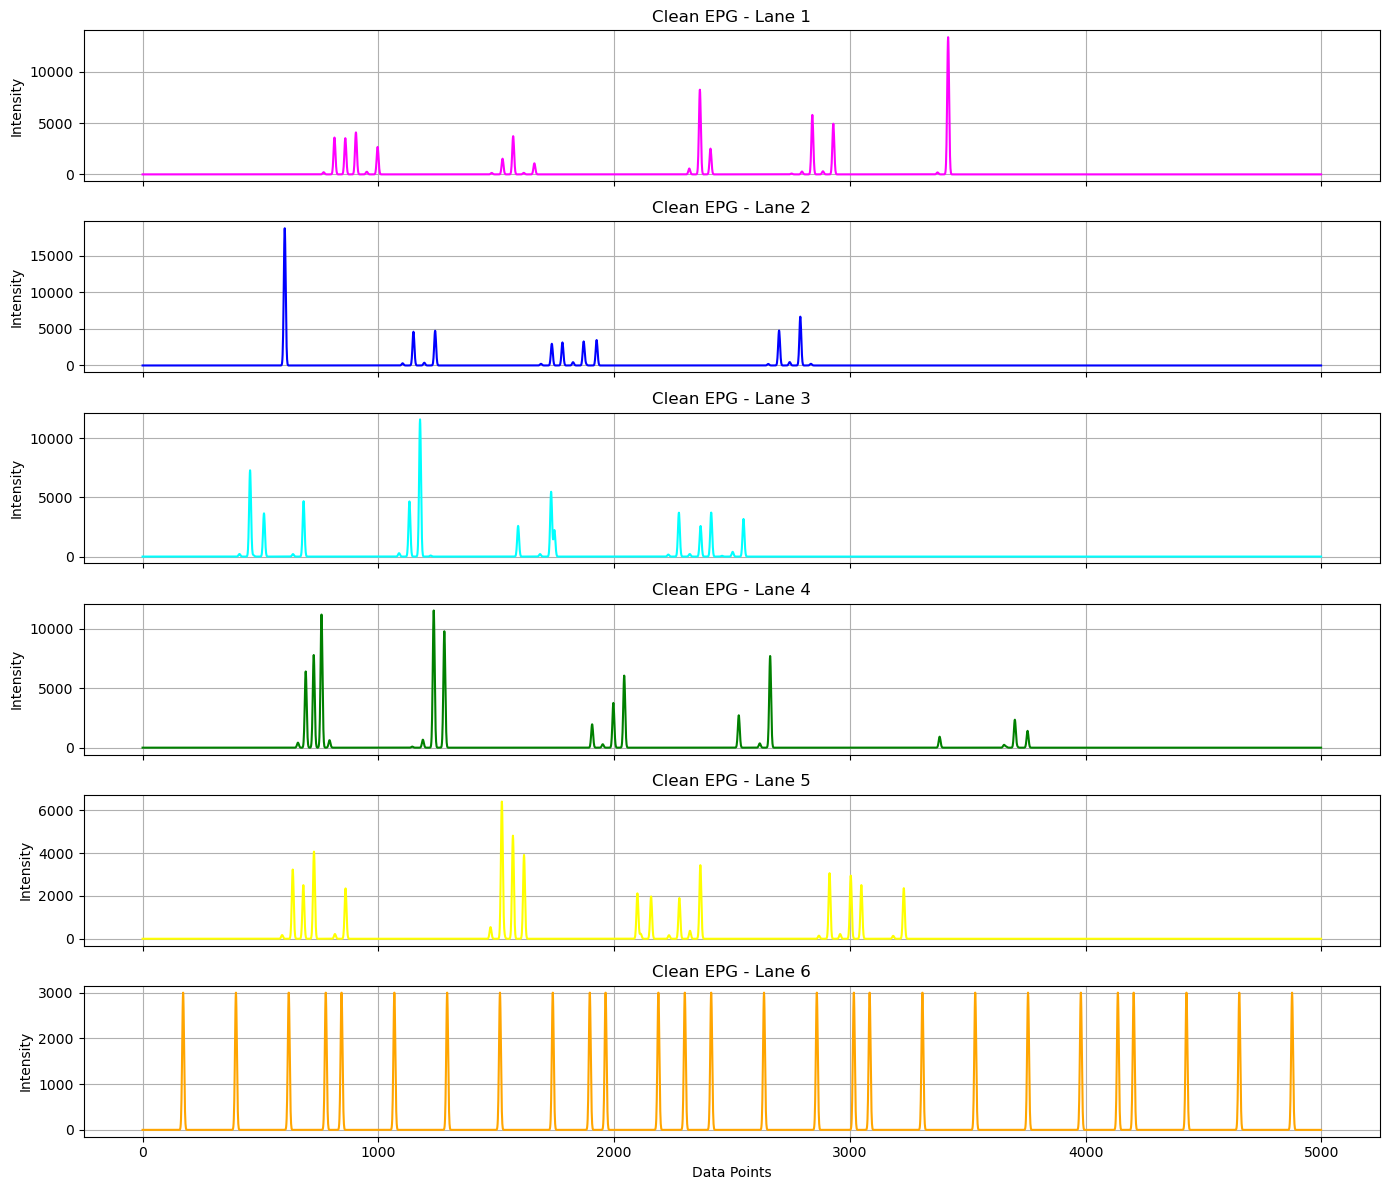

In [15]:
plot_epg(epg, no_dyes=6, title="Clean EPG")

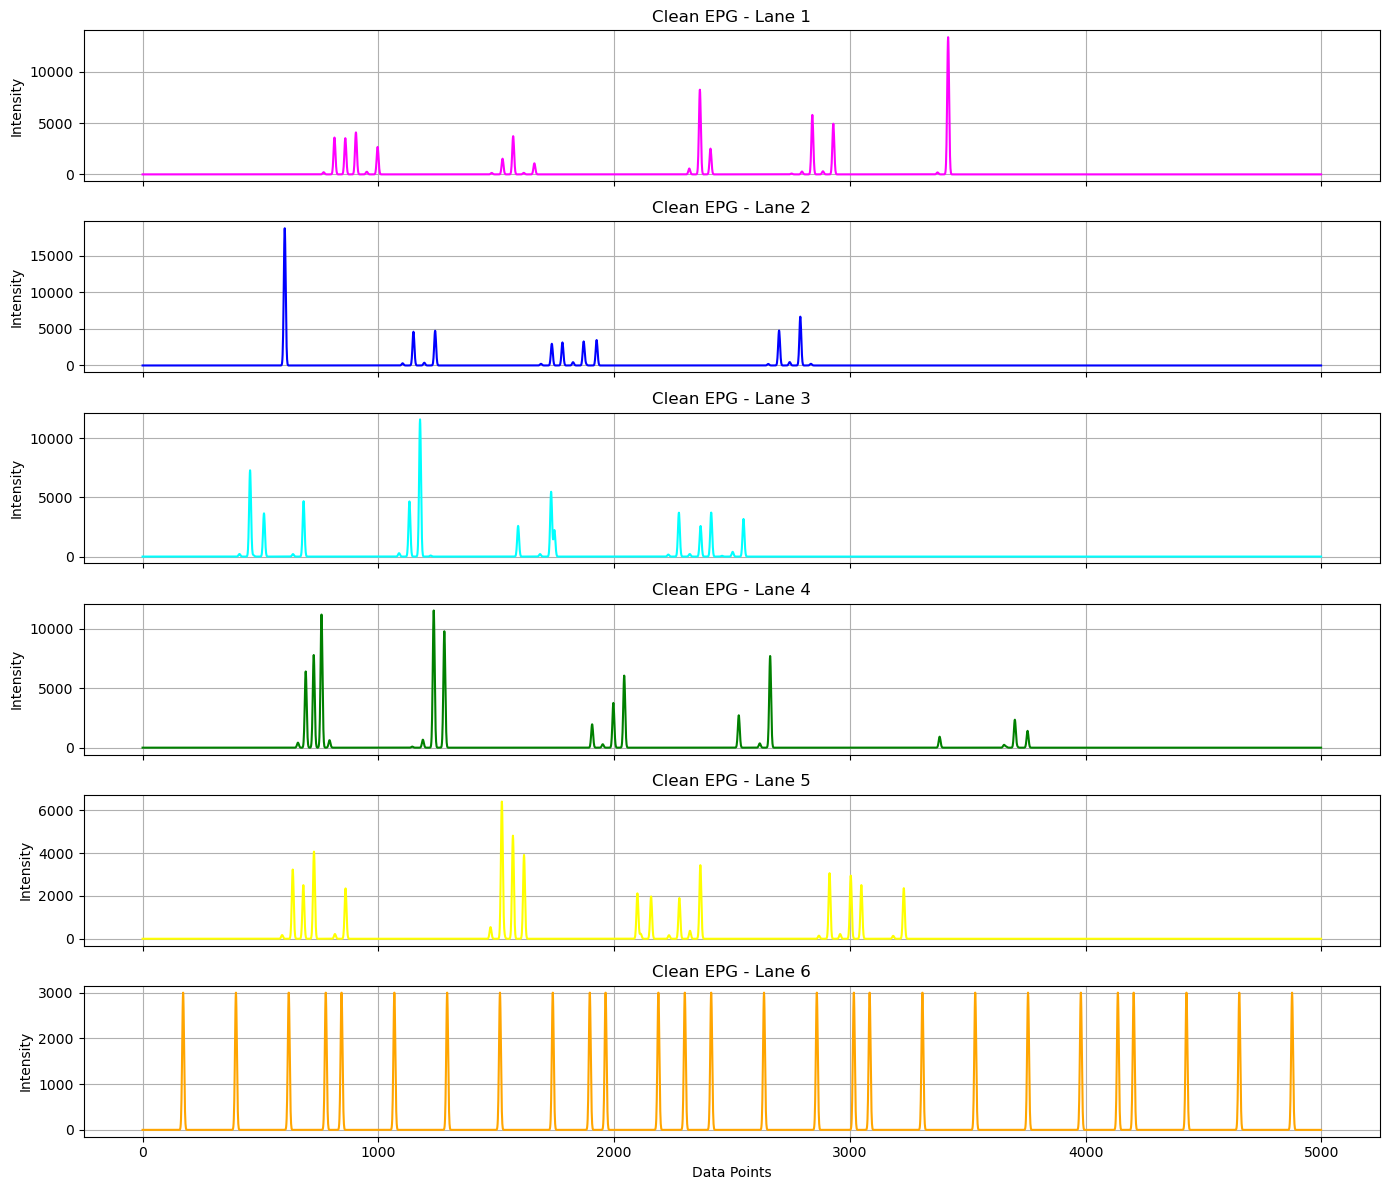

In [16]:
plot_epg(clean_epg, no_dyes=6, title="Clean EPG")

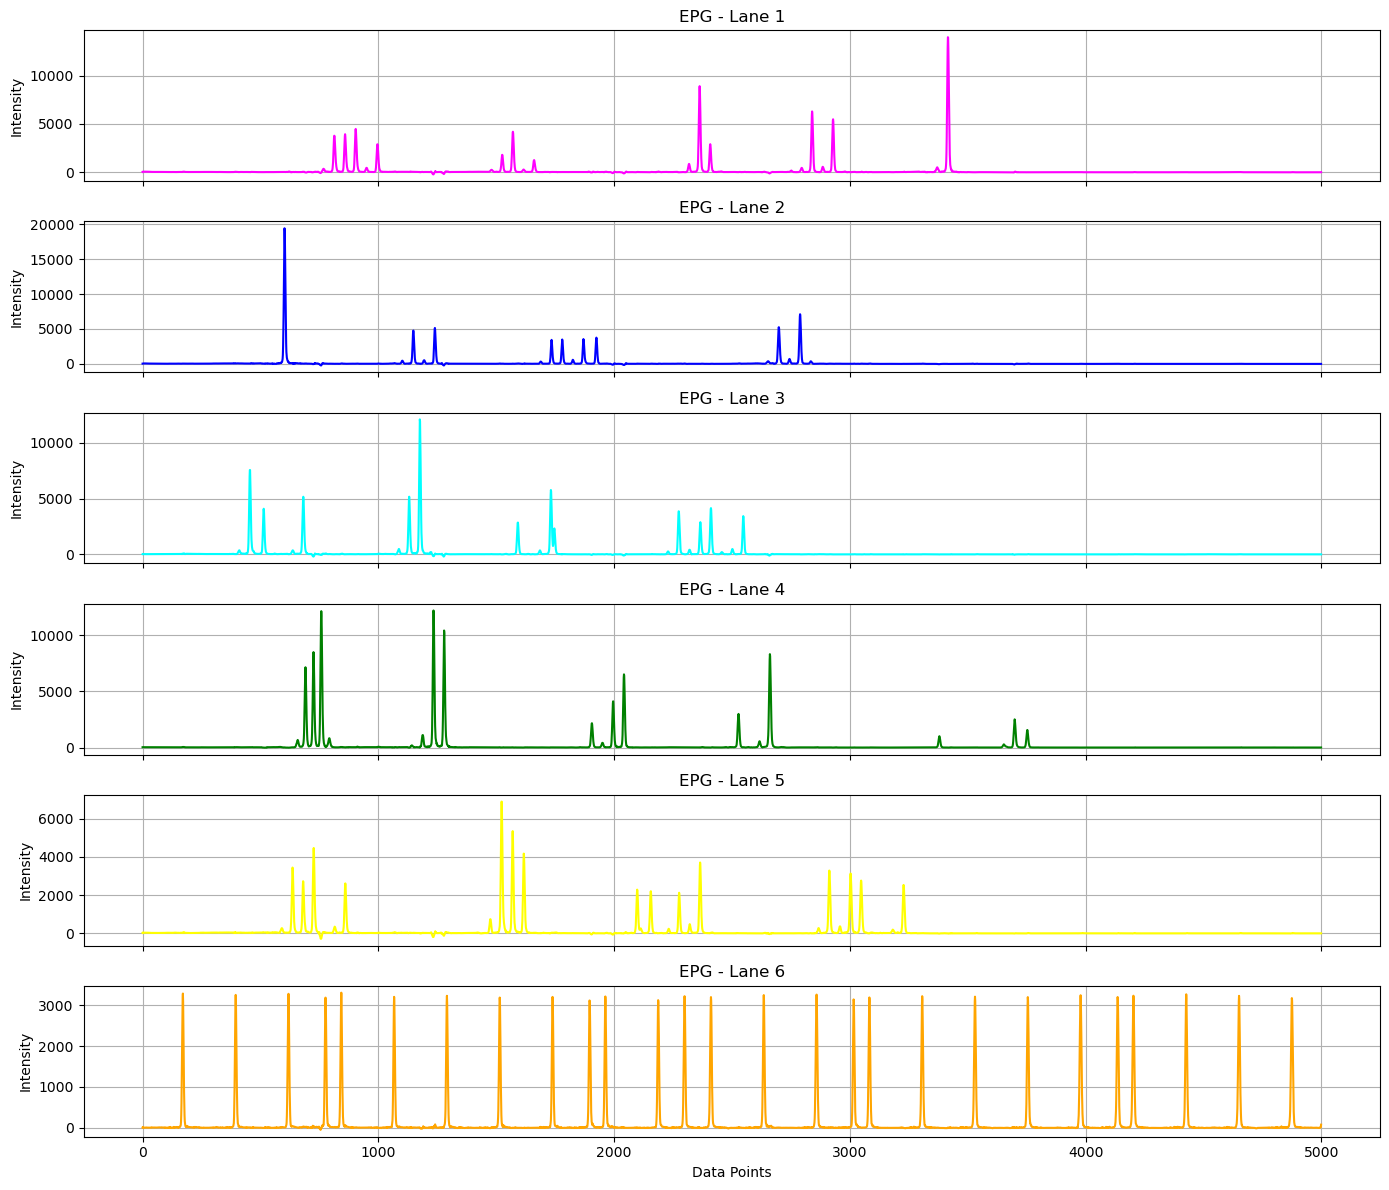

In [17]:
plot_epg(generated_epg, no_dyes=6, title="EPG")

In [ ]:
# # Colors for the 6 lanes
# lane_colors = ["magenta", "blue", "cyan", "green", "yellow", "orange"]

# fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16, 12), sharex=True)

# for i in range(6):
#     # Left column: noiseless EPG
#     axes[i, 0].plot(clean_epg[0, i, :, 0], color=lane_colors[i])
#     axes[i, 0].set_title(f"Lane {i+1} - Noiseless")
#     axes[i, 0].set_ylabel("Intensity")
#     axes[i, 0].grid(True)

#     # Right column: generated (noisy) EPG
#     axes[i, 1].plot(generated_epg[0, i, :, 0], color=lane_colors[i])
#     axes[i, 1].set_title(f"Lane {i+1} - Generated")
#     axes[i, 1].grid(True)

# # Set common X label for the bottom row
# axes[-1, 0].set_xlabel("Data Points")
# axes[-1, 1].set_xlabel("Data Points")

# plt.tight_layout()
# plt.show()


In [ ]:
# def generate_random_latent(batch_size=1, n_lanes=6, length=500):
#     # Normal distribution noise per lane, per position
#     return np.random.normal(loc=0.0, scale=0.0, size=(batch_size, n_lanes, length, 1))


# Generate a batch of clean EPGs
def epg_from_csv(csv_path, n_lanes=6, epg_length=5000, scan_min=4000, scan_max=9000, std_dev=4):

    df = pd.read_csv(csv_path)

    color_map = {"blue": 0, "green": 1, "yellow": 2, "red": 3, "purple": 4, "orange": 5}
    epg = np.zeros((1, n_lanes, epg_length, 1))

    # Fill in the EPG with Gaussian peaks based on the CSV data
    for _, row in df.iterrows():
        channel = color_map.get(row["Color"])
        center = int(round(row["Scan"]))
        height = row["Height"]

        start = max(center - 4 * std_dev, scan_min)
        end = min(center + 4 * std_dev, scan_max)

        x = np.arange(start, end)
        gaussian = height * np.exp(-0.5 * ((x - center) / std_dev) ** 2)

        epg[0, channel, x - scan_min, 0] += gaussian
    return epg


# Preprocess EPG: subtract baseline and scale
def preprocess_epg(epg):
    epg_bs = epg.copy()
    for channel in range(epg.shape[1]):
        baseline = mode(epg_bs[0, channel, :, 0], keepdims=False).mode
        epg_bs[0, channel, :, 0] -= baseline
    return epg_bs / 100.0


# Plotting function for EPG
def plot_epg(epg, no_dyes=6, title="EPG", save_path='epg', include_lane_standard=True):
    lane_colors = ["magenta", "blue", "cyan", "green", "yellow", "orange"]
    lanes = no_dyes if include_lane_standard else no_dyes - 1
    
    fig, axes = plt.subplots(lanes, 1, figsize=(14, 2.5 * lanes), sharex=True)
    if lanes == 1:
        axes = [axes]
    for i in range(lanes):
        axes[i].plot(epg[0, i, :, 0], color=lane_colors[i])
        axes[i].set_title(f"{title} - Lane {i+1}", fontsize=12)
        axes[i].set_ylabel("Intensity")
        axes[i].grid(True)
    axes[-1].set_xlabel("Data Points")
    plt.tight_layout()
    plt.savefig(f"{save_path}.pdf")
    plt.close(fig)

# # Example workflow for a single .csv file:
# no_epgs = 5
# dyes = 6
# latent = generate_random_latent(batch_size=no_epgs, n_lanes=dyes, length=500)

# csv_path = "simulated_epg_with_dyes.csv"
# clean_epg = preprocess_epg(epg_from_csv(csv_path))
# generated_epg = generator.predict([clean_epg, latent])


# # Save all 4 combinations
# for epg_tensor, epg_type in zip([clean_epg, generated_epg], ["clean", "generated"]):
#     for include_dye in [True, False]:
#         dye_str = "with_dye" if include_dye else "no_dye"
#         save_path = f"../generated_epgs/{epg_type}_epg_{dyes}_dyes_{dye_str}"
#         plot_epg(epg_tensor, no_dyes=dyes, title=f"{epg_type.capitalize()} EPG", save_path=save_path, include_lane_standard=include_dye)

import glob
import os

# Parameters
csv_dir = "./generated_alleles"
output_dir = "../generated_epgs"
dyes = 6
batch_size = 1  # Set to 1 unless you want to batch process multiple EPGs per file

# Find all relevant CSV files
csv_files = sorted(glob.glob(os.path.join(csv_dir, "simulated_epg_with_dyes_seed_*.csv")))

for i, csv_path in enumerate(csv_files):
    seed = i+1
    
    # Generate latent vector
    latent = generate_random_latent(batch_size=batch_size, n_lanes=dyes, length=500)
    
    # Generate EPGs
    clean_epg = preprocess_epg(epg_from_csv(csv_path))
    generated_epg = generator.predict([clean_epg, latent])
    
    # Save all 4 combinations
    for epg_tensor, epg_type in zip([clean_epg, generated_epg], ["clean", "generated"]):
        for include_dye in [True, False]:
            dye_str = "with_dye" if include_dye else "no_dye"
            save_path = f"{output_dir}/{epg_type}_epg_{dyes}_dyes_seed_{seed}_{dye_str}"
            plot_epg(epg_tensor, no_dyes=dyes, title=f"{epg_type.capitalize()} EPG (Seed {seed})", save_path=save_path, include_lane_standard=include_dye)

1/1 [==============================] - 0s 111ms/step
